# Prediction de faillite d'entreprises polonaises

Auteurs:
Selim Dekali &
Karim Benkirane



### Introduction :

Nous avons utilisé la base de données mise à disposition par l'UCI sur le site internet : "https://archive.ics.uci.edu/ml/machine-learning-databases/00365/"
Chacune des obervations de la base de données represente les caractériqtues financières d'une société polonaise sur 5 années. Notons que nous d'avons pas d'information permettant d'identifier les entreprises. 

Un label nous indique si l'entreprise est en faillite (1) ou non (0).

L'objectif de l'étude sera donc de prédire ce label en fonction des données financières continues disponible.

Certaines données ne sont pas renseignées et se pose ainsi la problématique de leurs traitements.

Par ailleurs, il s'avère que notre table est deséquilibrée, la très grande majorité des entreprises n'étant pas en faillite. Il s'agira donc de traiter ce point là afin de ne pas pénaliser nos prédictions.

Si l'on se place du point de vue d'un investisseur ou d'un banquier, l'enjeu de la prédiction  est de bien identifier les entreprises en faillite: l'erreur de prédiction n'est pas sysmétrique.


### Paramétrage:
1) Un fichier List_columns.csv est associé à ce notebook. Afin de l'exécuter correctement il faudra  détacher ce fichier csv, dans un repertoire local et indiquer ce chemin dans la variable ci-dessous : Path_To_List_Columns

2) Il faudra également renseigner un repertoire ou les données téléchargées depuis le site UCI seront sauvegardées et transformées, "Path_To_Save_Data". Merci de choisir un répertoire vide.






## Etape 1: Mise à disposition des données
    - On télécharge les bibliothèques nécessaires au projet
    - On télécharge les données
    


In [1]:
import pandas as pd
import numpy as np 
import scipy as sp
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import missingno as msno
from fancyimpute import KNN
import fancyimpute as fi

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\selim\Python Anaconda\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Paramétres utilisés au cours du projet:

In [2]:
#Paramètres de sauvegarde des données:
Path_To_Save_Data = "C:/Users/selim/OneDrive/Documents/selim/data science/ENSAE/Python/Project/Data/"
Path_To_List_Columns= "C:/Users/selim/OneDrive/Documents/selim/data science/ENSAE/Python/Project/"

#localisation des données:

url_data="https://archive.ics.uci.edu/ml/machine-learning-databases/00365/data.zip"


On télécharge et met les données au bon format, les données brut sont zippées et au format ARFF. Il y a 5 années d'historique qui sont ainsi transformées en 5 fichiers csv, afin d'être chargées.
Attention, compte tenu de la volumétrie des données, cela peut prendre quelques minutes, les données sont sauvegardées dans le repertoire mis en paramètre (Path_To_Save_Data)


In [6]:
import urllib.request
import zipfile

import os.path 

data,_ = urllib.request.urlretrieve(url_data)
zip_file_object = zipfile.ZipFile(data, 'r')

for counter, file_name in enumerate(zip_file_object.namelist()):
    content = zipfile.ZipFile.open(zip_file_object, name=file_name).read()
    localfile = open(Path_To_Save_Data+file_name, 'wb')
    localfile.write(content)
    localfile.close()

def listdirectory(path):  
    fichier=[]  
    for root, dirs, files in os.walk(path):  
        for i in files:  
            fichier.append(os.path.join(root, i))  
    return fichier

def arff2csv(arff_path, _encoding='utf8'):
    with open(arff_path, 'r', encoding=_encoding) as fr:
        attributes = []
        csv_path = arff_path[:-4] + 'csv'  # *.arff -> *.csv
        write_sw = False
        with open(csv_path, 'w', encoding=_encoding) as fw:
            for line in fr.readlines():
                if write_sw:
                    fw.write(line)
                elif '@data' in line:
                    fw.write(','.join(attributes) + '\n')
                    write_sw = True
                elif '@attribute' in line:
                    attributes.append(line.split()[1])  # @attribute attribute_tag numeric
        

List_Full_Path_Files = listdirectory(Path_To_Save_Data)

for counter, file in enumerate(List_Full_Path_Files):
    arff2csv(file)

On peut à present charger les données, afin de se constituer une base de données:
Une caractéristique intérressante de ce jeu de données est la presence de données manquantes, et la problématique sous jacente de comment les traiter.


In [3]:
List_Columns = pd.read_csv(Path_To_List_Columns+"List_Columns.csv", header=0)

df1 = pd.read_csv(Path_To_Save_Data + "1year.csv", delimiter=',', na_values='?')
df2 = pd.read_csv(Path_To_Save_Data + "2year.csv", delimiter=',', na_values='?')
df3 = pd.read_csv(Path_To_Save_Data + "3year.csv", delimiter=',', na_values='?')
df4 = pd.read_csv(Path_To_Save_Data + "4year.csv", delimiter=',', na_values='?')
df5 = pd.read_csv(Path_To_Save_Data + "5year.csv", delimiter=',', na_values='?')

df1['Year']= 1
df2['Year']= 2
df3['Year']= 3
df4['Year']= 4
df5['Year']= 5

frames= [df1,df2,df3,df4,df5]
df=pd.concat(frames)
col_names_original = list(df.columns.values)

column_indices = np.arange(65)
new_names = List_Columns['List_Columns'].values
old_names = df.columns[column_indices]
df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

df['missing value'] = df.isnull().any(1)
Years = df['Year']
Missing_value = df['missing value']
df = df.drop(['Year', 'missing value'],1)

## Etape 2: Description des données

Nous avons à présent chargées la base de données, intéressons nous à sa struture: 

In [5]:
print('la base de données contient {} lignes et {} colonnes'.format(*df.shape))
print(df.describe())

la base de données contient 43405 lignes et 65 colonnes
       net profit / total assets   total liabilities / total assets   \
count                43397.000000                       43397.000000   
mean                     0.035160                           0.590212   
std                      2.994109                           5.842748   
min                   -463.890000                        -430.870000   
25%                      0.003430                           0.268980   
50%                      0.049660                           0.471900   
75%                      0.129580                           0.688320   
max                     94.280000                         480.960000   

       working capital / total assets   \
count                     43397.000000   
mean                          0.114431   
std                           5.439429   
min                        -479.960000   
25%                           0.021521   
50%                           0.196610   
7

La base de données contient donc 43 405 observations réparties à peu près de façon équilibrées sur les 5 années,  elle a été mise à disposition par l'Université des Sciences et Technologie de Varsovie.
Chaque observation est décrite par 64 variables continues financières (ratio comptable permettant d'évaluer la situation financière de l'entreprise).
Les données présentes un grand intérêt afin d'évaluer la situation financière des entreprise et utilisent aussi bien des données provenant du Bilan que du compte de résultat. 
Néanmoins, nous notons qu'il manque de notre point de vue à ces données numériques des caractéristiques permettant de segmenter les observations. Ainsi dans l'idéal nous aurions souhaité rajouter à ces varaibles explicatives, des données qualitatives sur:
- le secteur d'activité (GICS Sector ou Industry): en effet, le secteur d'activité a une forte influence sur les ratios de liquidité, de dettes tolérées. Illustrons ceci par un exemple, si nous prenons une société de services aux collectivités (type EDF en France), ces entreprises présentes dans leur bilan une plus grande utilisation de la dette (liability), qu'une société d'un secteur cyclique telle que les sociétés de matériaux.
- zone de couverture: une société présente uniquement dans son pays d'origine sera plus sujette aux aléas macroéconomique de ce pays.

## Etape 2: Données manquantes

## A) Analyse descriptive 

In [ ]:
Intéressons nous à présent aux données manquantes

In [6]:
print( 'Il y a {} données manquantes sur la variable à prédire.'.format(df['class'].isnull().sum()))
print( 'Il y a {} données manquantes sur les features.'.format(df.isnull().sum().sum()))
print('Ceci represente {:{width}.{prec}f}% des données.'.format(df.isnull().sum().sum()*100/(df.shape[0]*df.shape[1]),
                                                                width=5, prec=1))



Il y a 0 données manquantes sur la variable à prédire.
Il y a 41322 données manquantes sur les features.
Ceci represente   1.5% des données.


Affichons à present le nombre de données manquantes par Features:

 - Nous remrquons dans le premier graphe qu'une Feature regroupe une large part des données manquantes, le graphique permet de visualiser ces données en fonctions des Features (axe horizontal), des observations (axe verticale)
 - le second graphique represente les donnéees manquantes suivant les Features, avec un axe logarithmique afin d'accentuer les différences
 Nous remarquons que la Feature '(current assets - inventories) / long-term liabilities ' rassemble un peu moins de la moitié des valeurs manquantes de l'ensemble de la base de données.

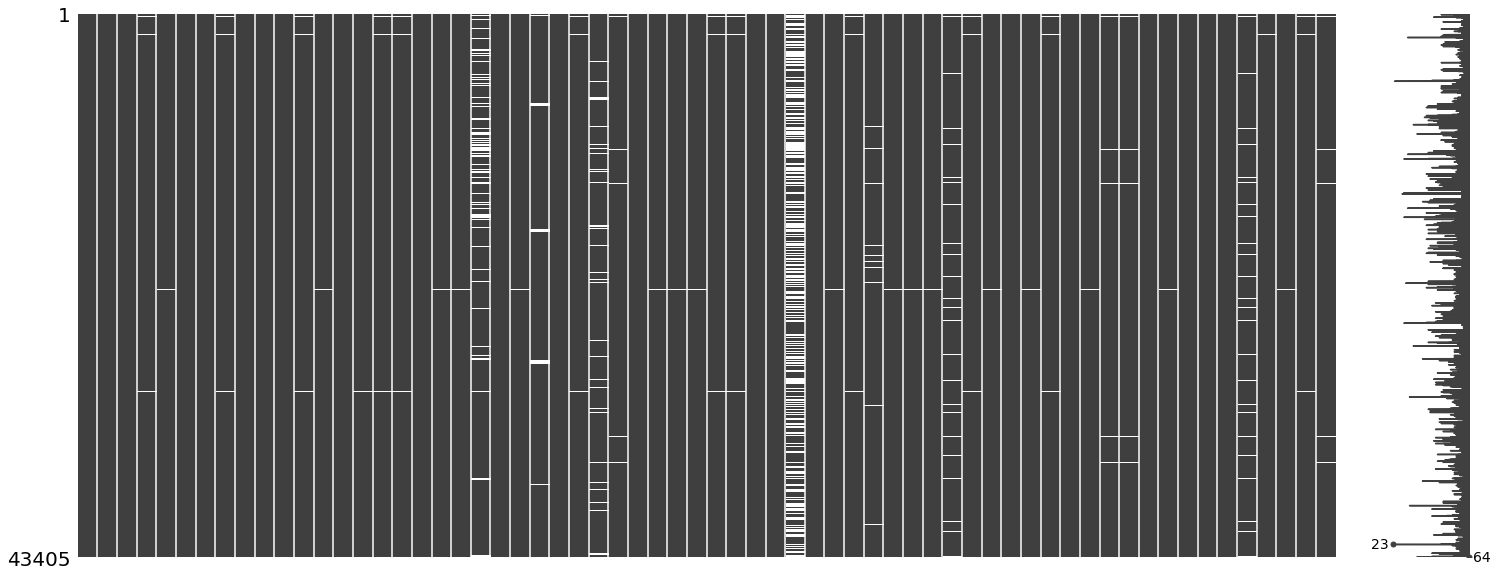

In [7]:
missingdata_df = df.columns[df.isnull().any()]
msno.matrix(df[missingdata_df])

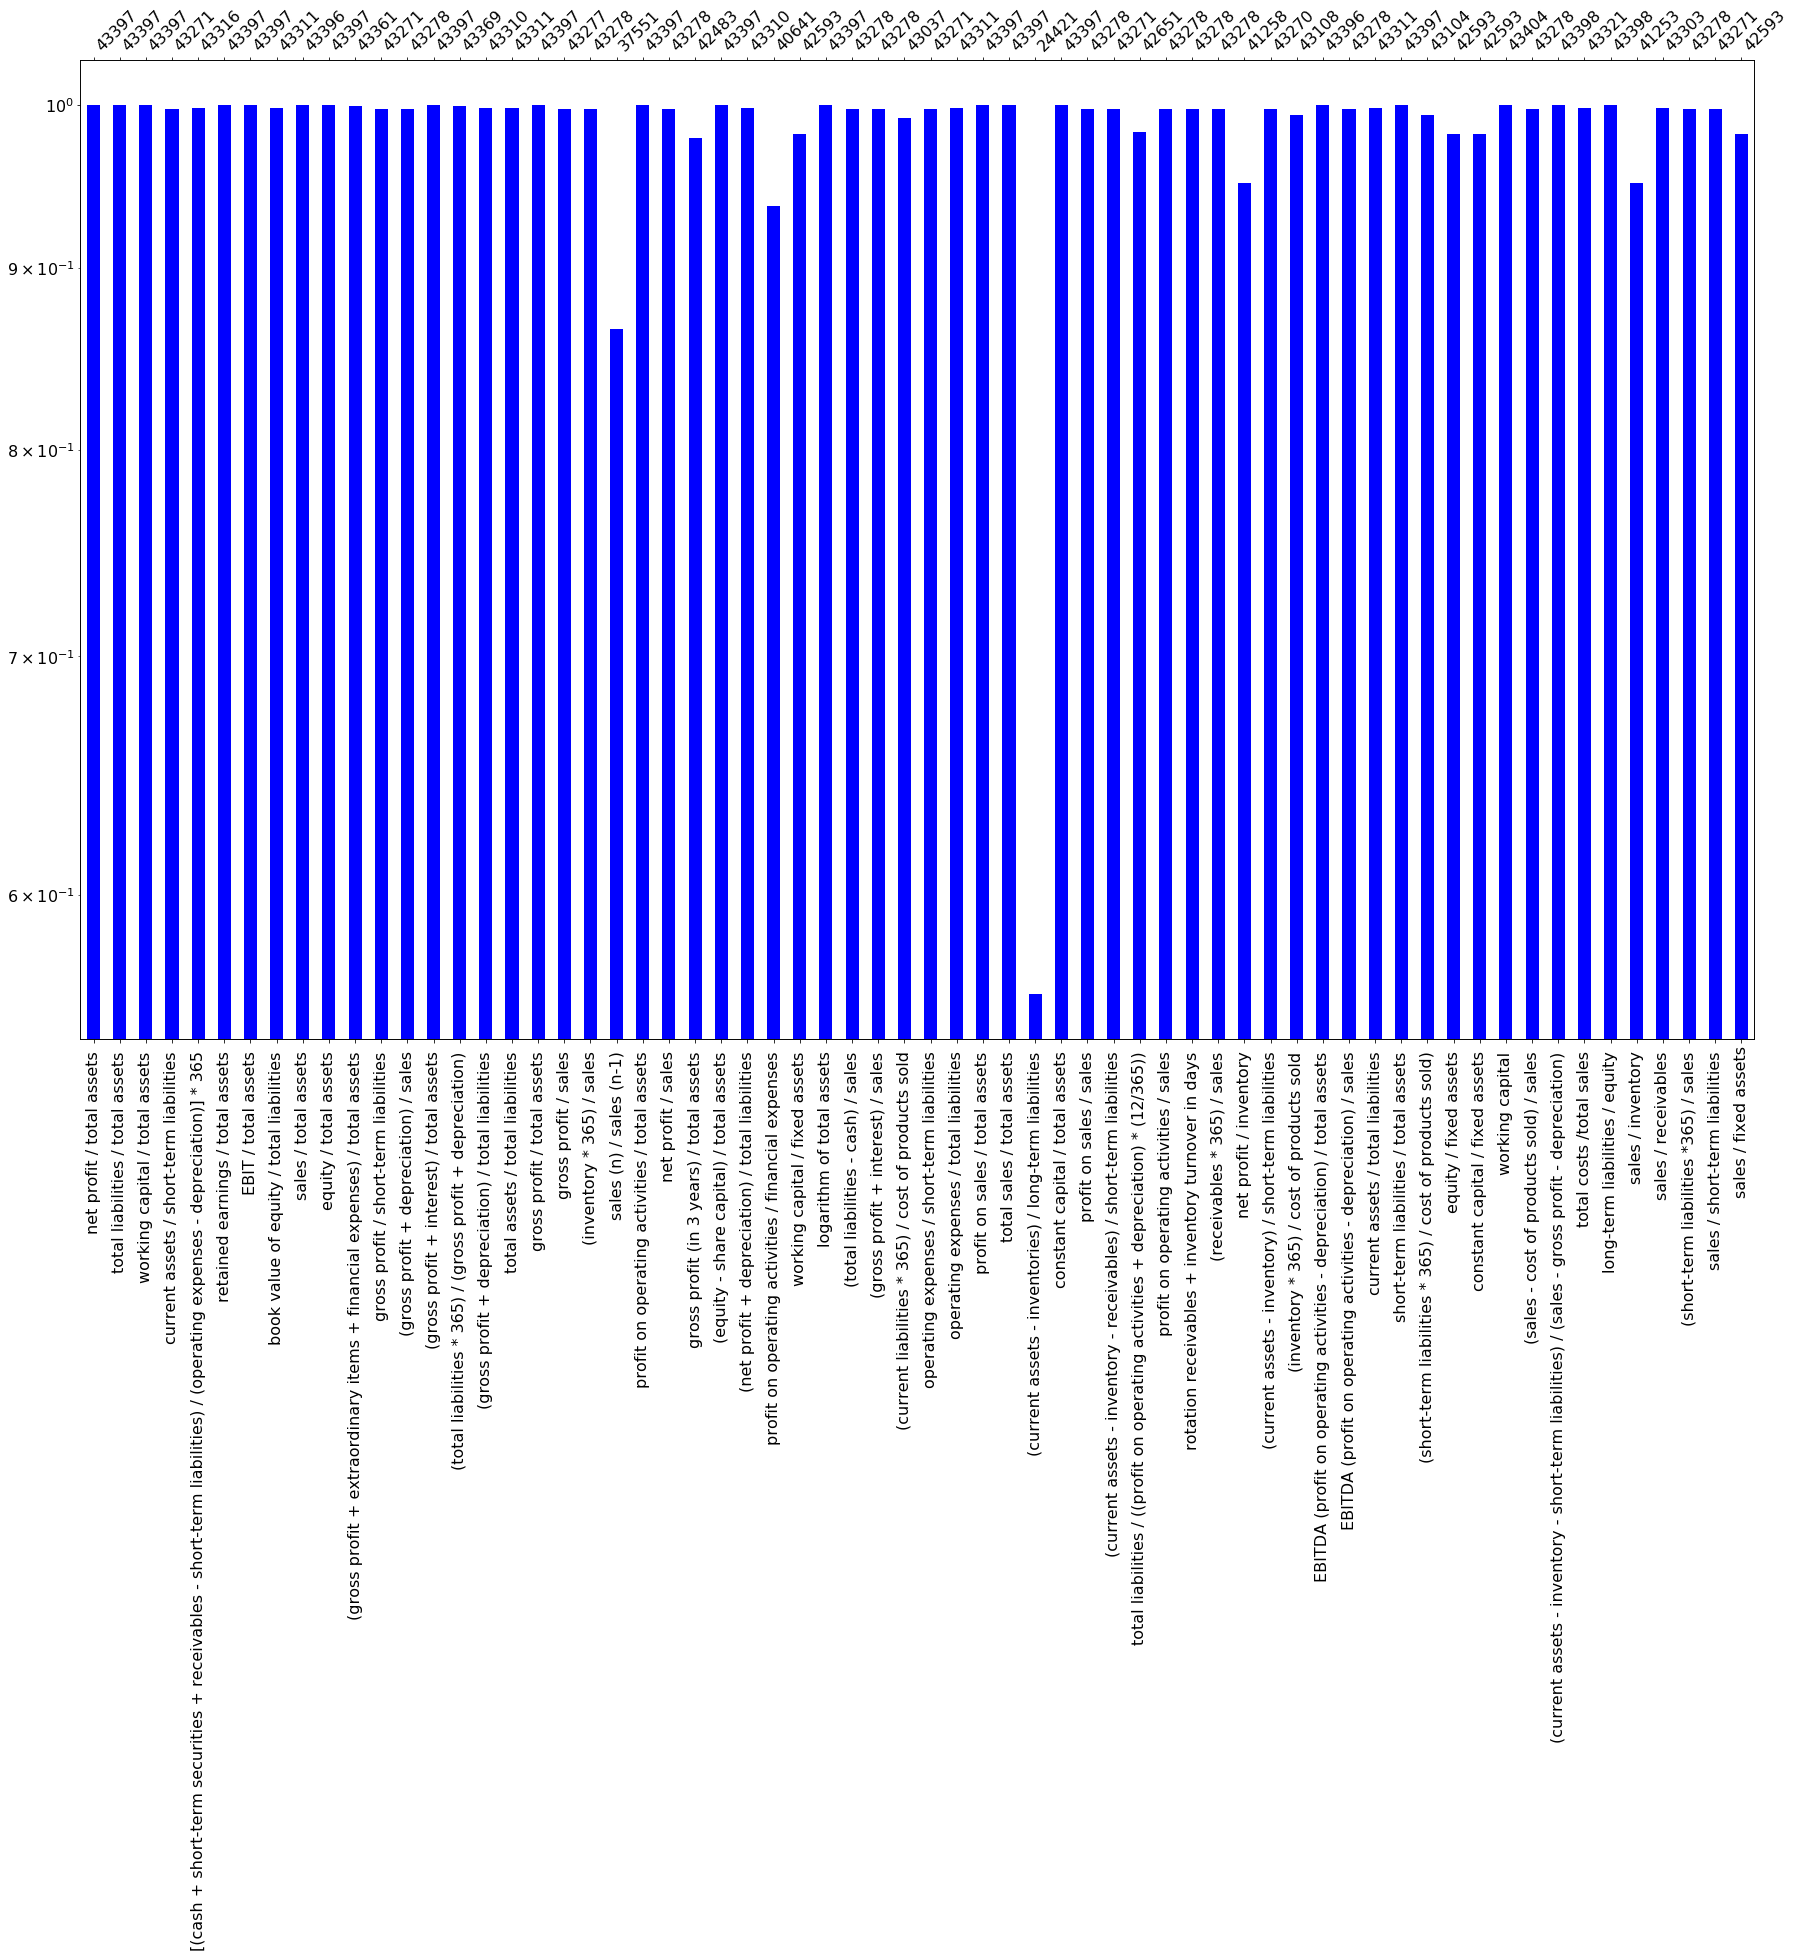

In [8]:
msno.bar(df[missingdata_df], color="blue", log=True, figsize=(30,18))

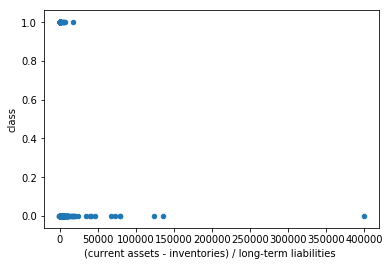

In [9]:
test=pd.concat([df['(current assets - inventories) / long-term liabilities '], df['class']], axis=1)
test.dropna().plot.scatter(0,1)
plt.show()


Cependant, cette feature presente des caractéristiques intéressantes, comme une analyse financière pouvait nous le laisser enisager les entreprises ayant un faible ratio 'current assets - inventories) / long-term liabilities ' ont une plus grande propension a être en faillite.

In [10]:
full= pd.concat([df,Years, Missing_value], axis=1)
full.groupby(['Year'])['class'].mean()

Year
1    0.038566
2    0.039320
3    0.047129
4    0.052594
5    0.069374
Name: class, dtype: float64

In [11]:
full.groupby(['Year', 'missing value'])['class'].mean()

Year  missing value
1     False            0.009393
      True             0.062875
2     False            0.017857
      True             0.053739
3     False            0.021904
      True             0.069064
4     False            0.025163
      True             0.078638
5     False            0.033652
      True             0.106982
Name: class, dtype: float64

In [12]:
full.groupby(['Year', 'missing value','class'])['class'].count()

Year  missing value  class
1     False          0        3164
                     1          30
      True           0        3592
                     1         241
2     False          0        4015
                     1          73
      True           0        5758
                     1         327
3     False          0        4778
                     1         107
      True           0        5230
                     1         388
4     False          0        4649
                     1         120
      True           0        4628
                     1         395
5     False          0        2929
                     1         102
      True           0        2571
                     1         308
Name: class, dtype: int64

Nous constatons que les observations contenant des données manquantes rassemble près de 3 fois plus de sociétés en bankrupt, ainsi se séparer de ces valeurs, en les excluant de façon naïve ferait perdre beaucoup d'information, surtout si l'on tient compte du faible taux de données manquantes (1.5% dont près de la moitié sur une seule Feature).

La colonne missing value indique ci-dessous qu'il existe une donnée manquante dans l'observations considérée. 

In [13]:
full.groupby(['Year', 'missing value', 'class']).mean()

net profit / total assets   \
Year missing value class                               
1    False         0                        0.082857   
                   1                        0.029748   
     True          0                        0.010485   
                   1                       -0.237471   
2    False         0                        0.046984   
                   1                       -0.017440   
     True          0                        0.044916   
                   1                       -0.023852   
3    False         0                        0.046195   
                   1                       -0.014429   
     True          0                        0.066387   
                   1                       -0.029264   
4    False         0                        0.042356   
                   1                       -0.066894   
     True          0                        0.056139   
                   1                       -0.069474   
5    False         0                        0.083650   
                   1                       -0.095785   
     True          0                        0.068929   
                   1                       -1.773028   

                          total liabilities / total assets   \
Year missing value class                                      
1    False         0                               0.533789   
                   1                               0.689258   
     True          0                               0.452140   
                   1                               2.500572   
2    False         0                               0.552209   
                   1                               0.754349   
     True          0                               0.626358   
                   1                               2.149088   
3    False         0                               0.554676   
                   1                               0.739043   
     True          0                               0.582251   
                   1                               1.898035   
4    False         0                               0.556209   
                   1                               0.776083   
     True          0                               0.605407   
                   1                               0.909425   
5    False         0                               0.381956   
                   1                               0.786291   
     True          0                               0.440288   
                   1                               1.358984   

                          working capital / total assets   \
Year missing value class                                    
1    False         0                             0.142183   
                   1                             0.059411   
     True          0                             0.229830   
                   1                            -1.800196   
2    False         0                             0.124483   
                   1                             0.014782   
     True          0                             0.120477   
                   1                            -1.448528   
3    False         0                             0.130346   
                   1                             0.028638   
     True          0                             0.157335   
                   1                            -1.148930   
4    False         0                             0.138639   
                   1                            -0.003975   
     True          0                             0.144865   
                   1                            -0.081339   
5    False         0                             0.165880   
                   1                            -0.040095   
     True          0                             0.306616   
                   1                            -0.495550   

                          current assets / short-term liabiliti

Interessons nous à present à la corrélation entre données manquantes, ce graphique, represente la corrélation entre données manquantes, (i.e. lien entre données manquantes de différentes Features), cela permet de capturer la probabilité qu'une Feature soit manquante sachant qu'une autre est manquante.

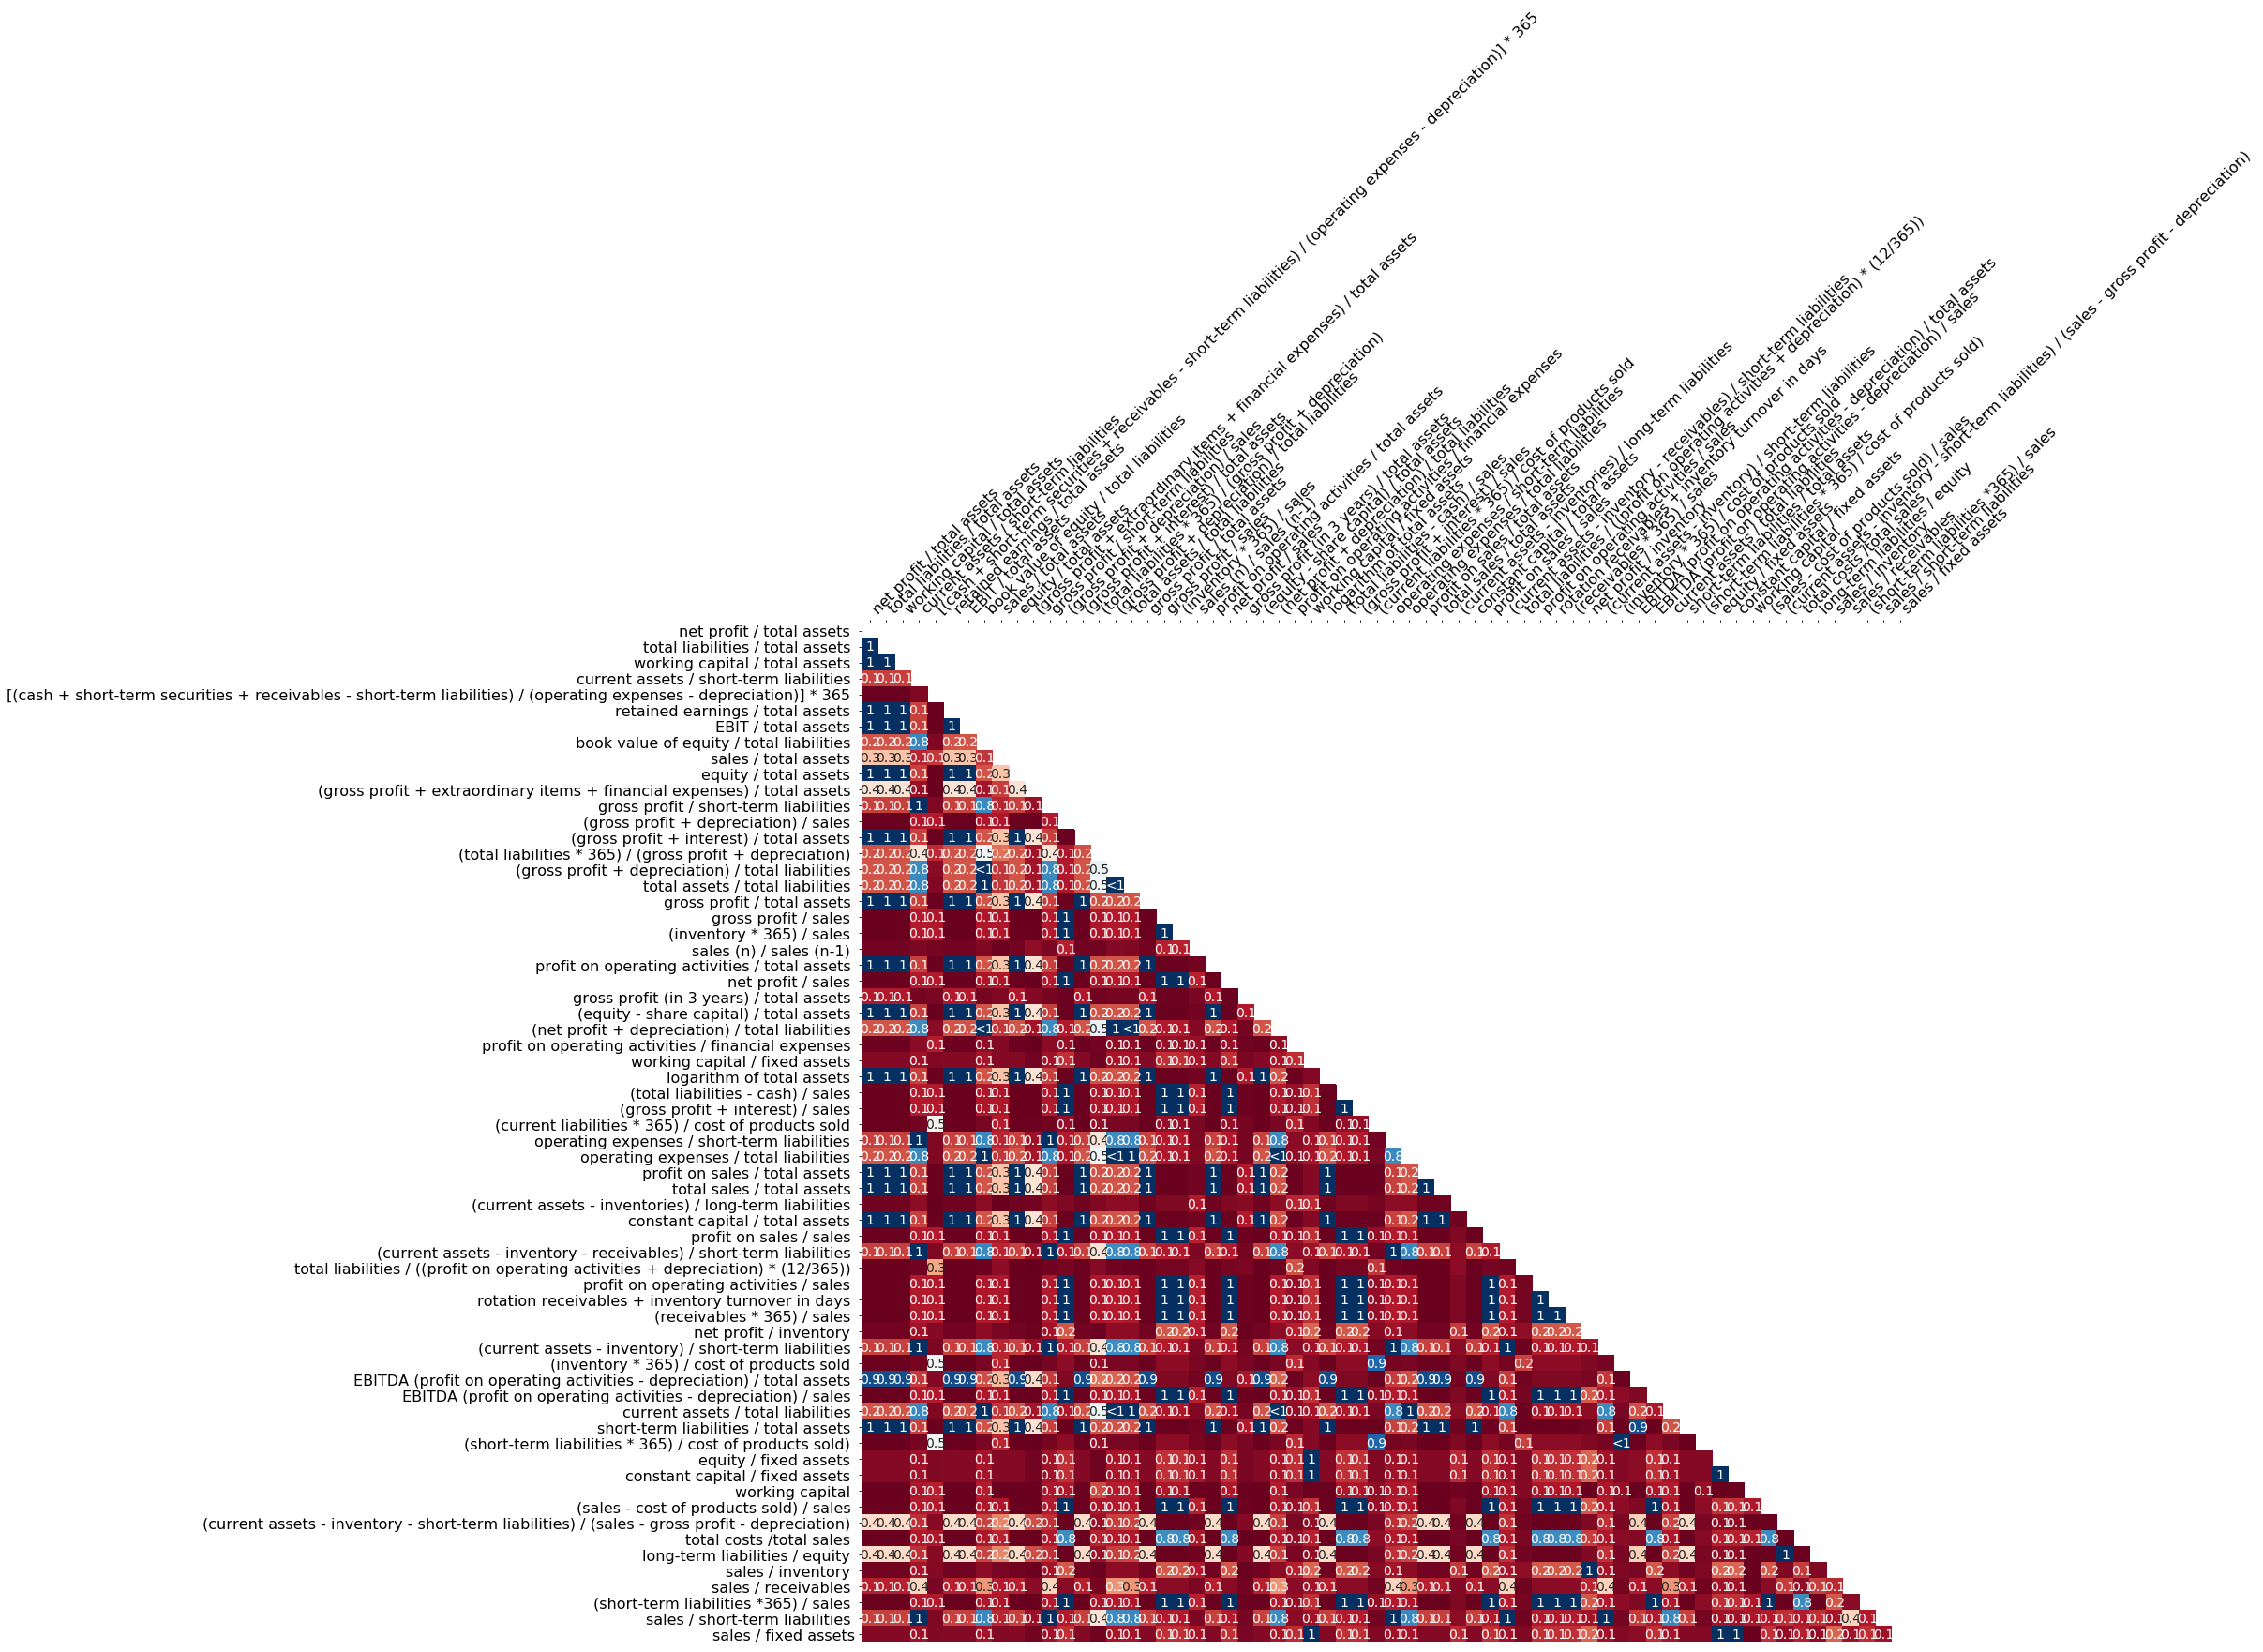

In [14]:
msno.heatmap(df[missingdata_df], figsize=(20,20))

Nous remarquons que les corrélations sont proches de 1 lorsque 2 Features partagent dans leur composition de ratio des composants en communs. (Ceci nous semble tout à convenable surtout compte tenu du taux de valeurs manquantes) et ne pas être dû au hazard.

## B) Imputation des données manquantes


Plusieurs stratégies existent pour éviter d'avoir des données manquantes:
 - supprimer ces observations: nous avons déjà exclue cette hypothèse compte tenu de l'information contenu dans ces observations
 - sckit learn a développer dans sa bibliothèque de preprocessing des données un module d'imputation, permettant de combler ces données avec soit la moyenne, soit la médiane, soit le mode de la Feature. Ceci nous semble également ne pas convenir, compte tenu du fait que comme énnoncé précédemment, que des sociétés de secteurs différents peuvent avoir des caractéristiques financières et ainsi des ratios (Features) très différentes. |||Ainsi cette stratégie pourrait même nous amener à perdre de l'information et être contre productif|||
 - Enfin d'autres stratégies d'imputation existe telles que le remplissage en utilisant l'algorithme des plus proches voisins...

In [4]:
data = pd.concat([df, Years], 1)
unique_years = [1,2,3,4,5]

def KNN_imputation (data):    
    #Missing value imputation in python using KNN, fancyimpute needs np.array 
    data = data.as_matrix()
    df_knn = pd.DataFrame(KNN(k=3).complete(data))    
    return df_knn

for counter, year in enumerate(unique_years):
    data_temp = data[data['Year']==year]
    data_temp = KNN_imputation(data_temp)
    if (counter == 0):
        df_knn_imputation = data_temp
    else:
        df_knn_imputation = pd.concat([df_knn_imputation, data_temp])


Imputing row 1/7027 with 0 missing, elapsed time: 34.753
Imputing row 101/7027 with 1 missing, elapsed time: 34.787
Imputing row 201/7027 with 2 missing, elapsed time: 34.788
Imputing row 301/7027 with 0 missing, elapsed time: 34.804
Imputing row 401/7027 with 0 missing, elapsed time: 34.819
Imputing row 501/7027 with 1 missing, elapsed time: 34.835
Imputing row 601/7027 with 1 missing, elapsed time: 34.847
Imputing row 701/7027 with 1 missing, elapsed time: 34.856
Imputing row 801/7027 with 0 missing, elapsed time: 34.856
Imputing row 901/7027 with 0 missing, elapsed time: 34.872
Imputing row 1001/7027 with 1 missing, elapsed time: 34.872
Imputing row 1101/7027 with 1 missing, elapsed time: 34.887
Imputing row 1201/7027 with 3 missing, elapsed time: 34.887
Imputing row 1301/7027 with 1 missing, elapsed time: 34.903
Imputing row 1401/7027 with 1 missing, elapsed time: 34.919
Imputing row 1501/7027 with 1 missing, elapsed time: 34.919
Imputing row 1601/7027 with 1 missing, elapsed time:

Imputing row 7401/10173 with 3 missing, elapsed time: 81.075
Imputing row 7501/10173 with 0 missing, elapsed time: 81.092
Imputing row 7601/10173 with 0 missing, elapsed time: 81.098
Imputing row 7701/10173 with 1 missing, elapsed time: 81.100
Imputing row 7801/10173 with 0 missing, elapsed time: 81.117
Imputing row 7901/10173 with 1 missing, elapsed time: 81.117
Imputing row 8001/10173 with 0 missing, elapsed time: 81.132
Imputing row 8101/10173 with 0 missing, elapsed time: 81.148
Imputing row 8201/10173 with 0 missing, elapsed time: 81.148
Imputing row 8301/10173 with 1 missing, elapsed time: 81.165
Imputing row 8401/10173 with 0 missing, elapsed time: 81.182
Imputing row 8501/10173 with 3 missing, elapsed time: 81.198
Imputing row 8601/10173 with 0 missing, elapsed time: 81.215
Imputing row 8701/10173 with 0 missing, elapsed time: 81.232
Imputing row 8801/10173 with 0 missing, elapsed time: 81.248
Imputing row 8901/10173 with 2 missing, elapsed time: 81.265
Imputing row 9001/10173 

Imputing row 1801/9792 with 1 missing, elapsed time: 74.088
Imputing row 1901/9792 with 0 missing, elapsed time: 74.091
Imputing row 2001/9792 with 0 missing, elapsed time: 74.108
Imputing row 2101/9792 with 1 missing, elapsed time: 74.115
Imputing row 2201/9792 with 1 missing, elapsed time: 74.117
Imputing row 2301/9792 with 1 missing, elapsed time: 74.131
Imputing row 2401/9792 with 0 missing, elapsed time: 74.137
Imputing row 2501/9792 with 0 missing, elapsed time: 74.142
Imputing row 2601/9792 with 1 missing, elapsed time: 74.146
Imputing row 2701/9792 with 0 missing, elapsed time: 74.163
Imputing row 2801/9792 with 0 missing, elapsed time: 74.163
Imputing row 2901/9792 with 0 missing, elapsed time: 74.179
Imputing row 3001/9792 with 1 missing, elapsed time: 74.196
Imputing row 3101/9792 with 1 missing, elapsed time: 74.197
Imputing row 3201/9792 with 0 missing, elapsed time: 74.214
Imputing row 3301/9792 with 0 missing, elapsed time: 74.230
Imputing row 3401/9792 with 1 missing, e

Imputing row 5801/5910 with 2 missing, elapsed time: 25.816
Imputing row 5901/5910 with 1 missing, elapsed time: 25.830


On normalise les données:
- tout d'abord supprimons la dernière colonne, correspondant à l'année
- ensuite on renomme les colonnes pour plus de facilité
- puis on normalise les données 

In [5]:
df_knn_imputation = df_knn_imputation.iloc[:, :-1]

In [6]:
def rename_columns(data):
    column_indices = np.arange(65)
    new_names = List_Columns['List_Columns'].values
    old_names = data.columns[column_indices]
    data.rename(columns=dict(zip(old_names, new_names)), inplace=True)   
    return data

df_knn_imputation = rename_columns (df_knn_imputation)

In [7]:
df_knn_imputation = pd.concat([df_knn_imputation, Years, Missing_value], axis = 1)

## Etape 3: Rééchantillonage

In [8]:
df_knn_imputation.iloc[:,64] = ['0' if b==0.0 else '1' for b in df_knn_imputation.iloc[:,64]]

In [9]:
df_knn_imputation.iloc[:,64].value_counts()

0    41314
1     2091
Name: class, dtype: int64

In [10]:
# on découpe notre table en deux, une partie avec la classe 0 et une autre à 1

df_majority = df_knn_imputation[df_knn_imputation.iloc[:,64]=="0"]
df_minority = df_knn_imputation[df_knn_imputation.iloc[:,64]=="1"]

# Augmentation de l'échantillon minoritaire pour le faire correspondre au majoritaire
from sklearn.utils import resample
df_minority_upsampled = resample(df_minority,replace=True,    
                                 n_samples=41314,
                                 random_state=123)
                                 

# Combinaison de la classe majoritaire avec la classe minoritaire rééchantillonée
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Affichons le nombre d'observations par classe à présent
df_upsampled.iloc[:,64].value_counts()

1    41314
0    41314
Name: class, dtype: int64

## Etape 4 : Normalisation VS Discrétisation

In [23]:
df_upsampled.iloc[:,0:63].agg(['mean','min','max','std'])

,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,...,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities
mean,-0.116602,1.079556,-0.347093,5.867866,-5.025881e+02,-0.641022,-0.081708,11.334604,2.302507,0.090425,...,32.849802,4.307587e+03,-1.534666e+01,-0.615053,1.627430e+01,0.936115,3.114976e+02,16.480053,1.592325e+03,9.002734
min,-463.890000,-430.870000,-479.960000,-0.403110,-1.190300e+07,-508.410000,-517.480000,-141.410000,-3.496000,-479.910000,...,-3828.900000,-1.805200e+06,-1.108300e+06,-1667.300000,-1.986900e+02,-327.970000,-1.244000e+01,-12.656000,-2.336500e+06,-1.543200
max,94.280000,480.960000,28.336000,53433.000000,1.250100e+06,543.250000,649.230000,53432.000000,9742.300000,1099.500000,...,180440.000000,6.123700e+06,2.931500e+02,552.640000,1.108300e+06,23853.000000,4.818700e+06,108000.000000,2.501600e+07,23454.000000
std,7.083975,13.808636,13.687563,247.484248,4.663409e+04,16.043113,7.913914,407.982449,45.680712,17.361371,...,1417.096972,5.419547e+04,3.857350e+03,24.949972,3.862569e+03,88.744705,2.361404e+04,402.978727,1.031225e+05,96.524892


In [12]:
#on met de côté la colonne de la cible
y = df_upsampled['class']
year= df_upsampled['Year']
missing_value=df_upsampled['missing value']
X = df_upsampled.drop(['class','Year', 'missing value'],1)
Col_Names = list(X.columns.values)

In [25]:
#On normalise les données
def normalize(data):
    scaler = StandardScaler()
    df_standardized = scaler.fit_transform(data)
    return df_standardized
X_normalized = normalize(X)


In [26]:
X_normalized_c = np.concatenate((X_normalized, np.array(year.values, copy=False, subok=True, ndmin=2).T,
                                 np.array(missing_value.values, copy=False, subok=True, ndmin=2).T), axis = 1)
Col_Names.append(Years.name)
Col_Names.append(Missing_value.name)

In [13]:
#On reprend le X qui ne contient que les features et faisons la discrétisation

X_discret= X.apply(lambda x: pd.qcut(x.rank(method='first'), 4), axis=0)


## Etape 5: Analyse des Features

In [ ]:
Affichons les corrélations existantes entre nos features

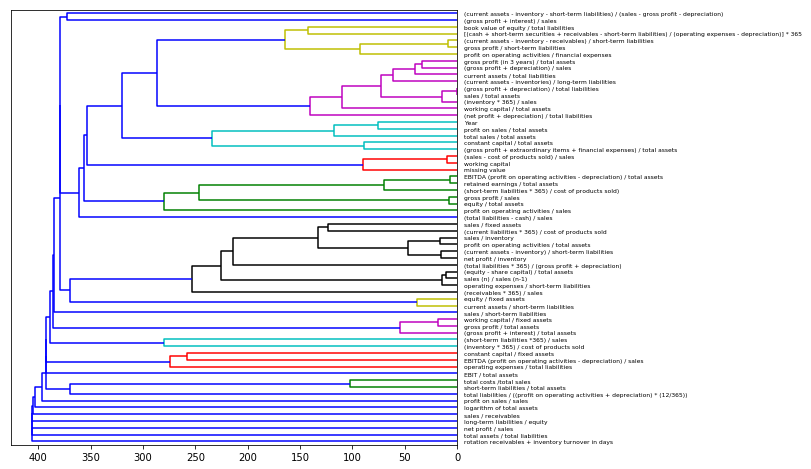

In [29]:
from fastcluster import linkage
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

data_link = linkage(X_normalized.T, method = 'single', metric = 'euclidean', preserve_input = True)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
dendrogram(data_link, labels=Col_Names, show_leaf_counts=True, ax=ax, orientation = "left")
plt.show()


## Etape 7: Modélisation

## Modèle 1: XGboost

In [34]:
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import cross_val_score

C:\Users\selim\Python Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
#on met de côté la colonne de la cible
y_n = df_knn_imputation['class']
year= df_knn_imputation['Year']
missing_value=df_knn_imputation['missing value']
X = df_knn_imputation.drop(['class','Year', 'missing value'],1)
Col_Names = list(X.columns.values)

In [31]:
#On normalise les données
def normalize(data):
    scaler = StandardScaler()
    df_standardized = scaler.fit_transform(data)
    return df_standardized
X_normalized = normalize(X)

In [32]:
#On sépare les données 
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_n, test_size=0.33)

In [35]:
%%time

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

thresholds = np.sort(model.feature_importances_)
results = np.zeros((len(thresholds),3))

i=0
for thresholds_iter in thresholds:
    # select features using threshold
    from sklearn.feature_selection import SelectFromModel 
    selection = SelectFromModel(model, threshold = thresholds_iter, prefit = True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgb.XGBClassifier()
    scores = cross_val_score(selection_model, select_X_train, y_train, cv=5, scoring='accuracy', n_jobs=1, verbose=0)

    results[i,0] = np.mean(scores)
    results[i,1] = np.std(scores)
    results[i,2] = thresholds_iter
    
    i = i + 1
    if i % 5 == 0:
        print ('Iteration',i,'sur', len(thresholds))
    
best_tresholds = results[np.min(np.where(results[:,0] == np.max(results[:,0]))),2]
print ('Best threshold :' ,best_tresholds)
print ('Le nombre de features rejeté est de :', np.min(np.where(results[:,0] == np.max(results[:,0]))), ',sur 64.')
selection = SelectFromModel(model, threshold = best_tresholds, prefit=False)
selection.fit(X_train, y_train)
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)


Iteration 5 sur 64
Iteration 10 sur 64
Iteration 15 sur 64
Iteration 20 sur 64
Iteration 25 sur 64
Iteration 30 sur 64
Iteration 35 sur 64
Iteration 40 sur 64
Iteration 45 sur 64
Iteration 50 sur 64
Iteration 55 sur 64
Iteration 60 sur 64
Best threshold : 0.0145772593096
Le nombre de features rejeté est de : 43 ,sur 64.
Wall time: 15min 43s


In [36]:
from itertools import compress
fil = model.feature_importances_>=selection.threshold_
print('la liste des features retenues est :')
list(compress(Col_Names, fil))

la liste des features retenues est :


['[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365 ',
 'retained earnings / total assets ',
 'sales / total assets ',
 '(gross profit + depreciation) / sales ',
 '(inventory * 365) / sales ',
 'profit on operating activities / total assets ',
 'gross profit (in 3 years) / total assets ',
 '(equity - share capital) / total assets ',
 '(net profit + depreciation) / total liabilities ',
 'profit on operating activities / financial expenses ',
 'logarithm of total assets ',
 'operating expenses / total liabilities ',
 'profit on sales / total assets ',
 'total sales / total assets ',
 'constant capital / total assets ',
 'profit on sales / sales ',
 '(current assets - inventory - receivables) / short-term liabilities ',
 '(current assets - inventory) / short-term liabilities ',
 '(sales - cost of products sold) / sales ',
 'total costs /total sales ',
 'sales / receivables ']

Si l'on rapproche cette liste du dendrogramme, nous remarquons que les features retenues sont les plus éloignées. 

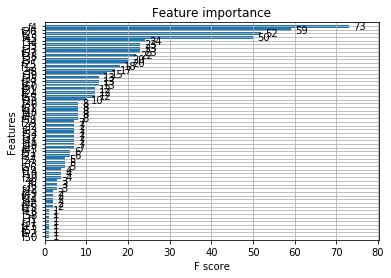

In [37]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

xgb.plot_importance(model,height=0.8)
plt.show()

In [38]:
clf = xgb.XGBClassifier(silent=False)

In [39]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [40]:
from scipy.stats import randint as sp_randint

# specify parameters and distributions to sample from
param_dist = {'max_depth': sp.stats.randint(2,7),
             'n_estimators' :sp.stats.randint(150,300),
              'subsample': sp.stats.uniform(0.85,0.15),
              'colsample_bytree': sp.stats.uniform(0.85,0.15)
}

In [41]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from time import time


# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

start = time()
random_search.fit(select_X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)



RandomizedSearchCV took 2847.79 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.969 (std: 0.002)
Parameters: {'colsample_bytree': 0.95663382441596856, 'max_depth': 6, 'n_estimators': 280, 'subsample': 0.86881504263577636}

Model with rank: 2
Mean validation score: 0.969 (std: 0.002)
Parameters: {'colsample_bytree': 0.95302635782601819, 'max_depth': 5, 'n_estimators': 293, 'subsample': 0.86245750312779357}

Model with rank: 3
Mean validation score: 0.969 (std: 0.002)
Parameters: {'colsample_bytree': 0.915538497247529, 'max_depth': 6, 'n_estimators': 286, 'subsample': 0.91328573978947192}

Wall time: 47min 27s


## Prédiction et performance du modèle 

In [104]:
best_wgbc = random_search.best_estimator_


best_wgbc.fit(select_X_train, y_train)

y_pred = best_wgbc.predict(select_X_test)
y_proba = best_wgbc.predict_proba(select_X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))


from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test, y_pred)
print(conf)

0.965721865401
[[13579    34]
 [  457   254]]


In [26]:
class_names = ['0','1']
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="left",
                 color="red")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.figure()

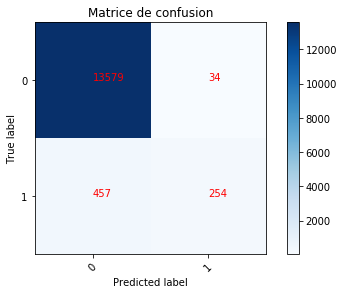

In [43]:
np.set_printoptions(precision=3)
plt.figure()
plot_confusion_matrix(conf, classes=class_names,
                      title='Matrice de confusion')
plt.show()

### Commentaire:
- le modèle XGBoost a un taux de bonne prédictionde 96%, cependant le modèle a tendance à mal classer les entreprises en faillite (64% des entreprises en faillite mal classé).
- malgré tout l'algorithme grace a son boosting (pénaliser les erreurs) permet d'avoir une meilleur prédiction qu'une stratégie qui prédirait toujours une non faillite.

A partir de maintenant nous allons travailler sur des données rééchantillonnées afin de palier le deséquilibre de la table. 
 

## Modèle 2: Régression logistique

Ici nous mettons en oeuvre un modèle logistique sur les données discrétisées

## Découpage des données en train et test

In [44]:
#on met de côté la colonne de la cible
y = df_upsampled['class']
year= df_upsampled['Year']
missing_value=df_upsampled['missing value']
X = df_upsampled.drop(['class','Year', 'missing value'],1)
Col_Names = list(X.columns.values)

In [45]:
#On reprend le X qui ne contient que les features et faisons la discrétisation

X_discret= X.apply(lambda x: pd.qcut(x.rank(method='first'), 4), axis=0)

In [46]:
#On sépare les données 
X_train_discret, X_test_discret, y_train_discret, y_test_discret = train_test_split(X_discret, y, test_size=0.33)

In [47]:
# Importing LabelEncoder and initializing it
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
# Iterating over all the common columns in train and test
for col in X_test_discret.columns.values:
       # Encoding only categorical variables
    if X_test_discret[col].dtypes=='category':
        # Using whole data to form an exhaustive list of levels
        X_discretise_encode=X_train_discret[col].append(X_test_discret[col])
        le.fit(X_discretise_encode.values)
        X_train_discret[col]=le.transform(X_train_discret[col])
        X_test_discret[col]=le.transform(X_test_discret[col])
        
     

C:\Users\selim\Python Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\selim\Python Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


## Sélection des features par Cross validation

Procédons à la séléction de nos features par cross validation, les variables séléctionnées sont celles 
qui permettent la maximisation du score de précision obtenu à travers la cross validation 
(qui découpe notre échantillon train en 5-fold en faisant le test de prédiction sur le 5-1 fold )

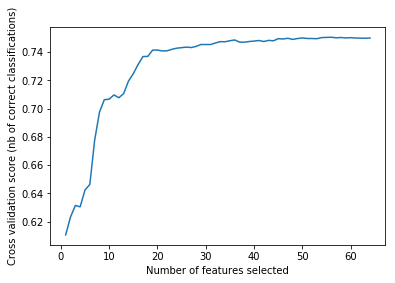

Le nombre optimal de features est : 56


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

logreg = LogisticRegression()
logreg.fit(X_train_discret, y_train_discret)

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=logreg, step=1, cv=StratifiedKFold(5),
              scoring='accuracy')
rfecv.fit(X_train_discret, y_train_discret)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print("Le nombre optimal de features est : %d" % rfecv.n_features_)

In [49]:
#Le vecteur qui suit contient la position des features à retenir dans le modèle
Supprt=np.array(rfecv.support_)

#Ici nous gardons dans l'échatillon train et test que les features sélectionnés

X_train_logistic=X_train_discret.iloc[:,Supprt]
X_test_logistic=X_test_discret.iloc[:,Supprt]


Tunning des paramètres par Cross validation:
Procédons au tunning des paramètres de notre régression logistique en ayant recours au GridsearchCV sur notre modèle 
avec les features retenues précédemment. (toujours avec 5 folds)

In [50]:
from sklearn.model_selection import GridSearchCV
grid_values  = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
grid_log_discret = GridSearchCV(LogisticRegression(), param_grid=grid_values,cv=StratifiedKFold(5))
clf_log_discret= grid_log_discret.fit(X_train_logistic,y_train_discret)
print("Les paramètres optimaux du modèle sont :")
print(clf_log_discret.best_estimator_.get_params())

Les paramètres optimaux du modèle sont :
{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


### Performance et précision du modèle

Affichage des scores de précision à chaque K-Fold de la cross validation

In [65]:
from sklearn.model_selection import cross_val_score
K_fold = StratifiedKFold(n_splits=5)
score_log_discret =cross_val_score(grid_log_discret, X_train_logistic, y_train_discret, cv=K_fold, n_jobs=-1)
score_log_discret

array([ 0.758,  0.747,  0.749,  0.752,  0.75 ])

In [66]:
#Le score moyen
print("Le score moyen de la cross validation est :")
print(np.mean(score_log_discret))

Le score moyen de la cross validation est :
0.751192196532


### Analyse de la performance par appliquation à l'échantillon test

Maintenant que nous avons obtenu un premier aperçu de la performance de notre modèle par cross-validation, interessons nous à 
son appliquation sur l'échantillon test que nous avons mis de côté pour jauger son efficacité.

In [51]:
y_pred_log_discret = grid_log_discret.fit(X_train_logistic,y_train_discret).predict(X_test_logistic)
#Affichage du score de bonne prédiction
print("Le score de bonne prédiction est :")
print(accuracy_score(y_pred_log_discret, y_test_discret) )


Le score de bonne prédiction est :
0.748716444184


In [52]:
clf_log_discret.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

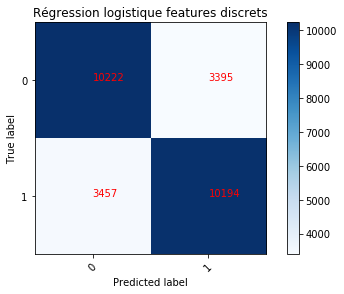

In [53]:
cnf_matrix_log_discret=confusion_matrix(y_test_discret, y_pred_log_discret)
plot_confusion_matrix(cnf_matrix_log_discret, classes=class_names,
                      title='Régression logistique features discrets')    
plt.show()

## Commentaire:
Nous avons rééchantilloné les données afin d'équilibrer la table et avons un score de bonne prédiction sur l'échantillon test (resamplé) de 75%, qui est très proche du taux moyenne donné de bonne prédiction de la cross validation.
Nous remarquons une forte symétrie de la matrice de confusion, et seulement 25% d'entreprise en faillite classé en non faillite.



## Modèle 3 : KNN

Ici nous mettons en oeuvre une classification KNN sur les données discrétisées

### Tunning des paramètres par Cross validation

Procédons au tunning des paramètres de notre KNN en ayant recours au GridsearchCV sur notre modèle. (toujours avec 5 folds). Ici nous cherchons à avoir le nombre de voisins optimal ainsi que le type de calcul de distance optimal

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

k = np.arange(5, 11, 2)
grid_valuesknn= {'n_neighbors': k, 'weights':('uniform', 'distance')}
grid_KNN_discret = GridSearchCV(KNeighborsClassifier(),param_grid=grid_valuesknn, cv=StratifiedKFold(5))
clf_KNN_discret= grid_KNN_discret.fit(X_train_discret,y_train_discret)
print("Les paramètres optimaux du modèle sont :")
print(clf_KNN_discret.best_estimator_.get_params())

Les paramètres optimaux du modèle sont :
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}


### Affichage des scores de précision à chaque K-Fold de la cross validation


In [ ]:
score_KNN_discret =cross_val_score(grid_KNN_discret, X_train_discret, y_train_discret, n_jobs=-1)


In [ ]:
#Le score moyen
print("Le score moyen de la cross validation est :" )
print(np.mean(score_KNN_discret))

### Analyse de la performance par appliquation à l'échantillon test

Maintenant que nous avons obtenu un premier aperçu de la performance de notre modèle par cross-validation, interessons nous à 
son appliquation sur l'échantillon test que nous avons mis de côté pour jauger son efficacité.

In [23]:
from sklearn.metrics import accuracy_score

y_pred_KNN_discret = grid_KNN_discret.predict(X_test_discret)
#Affichage du score de bonne prédiction
print("Le score de bonne prédiction est :")
print ( accuracy_score(y_pred_KNN_discret, y_test_discret) )
     

Le score de bonne prédiction est :
0.943450198034


### Affichons la matrice de confusion

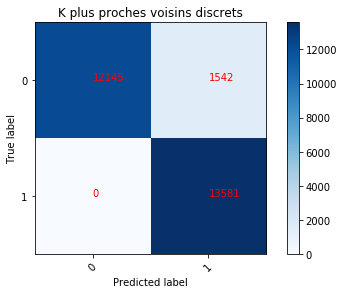

In [28]:
from sklearn.metrics import confusion_matrix

cnf_matrix_KNN_discret=confusion_matrix(y_test_discret, y_pred_KNN_discret)
plot_confusion_matrix(cnf_matrix_KNN_discret, classes=class_names,
                      title='K plus proches voisins discrets')  
plt.show()

# Comparaison des courbes ROC des modèles

In [55]:
#Calcul des probabilités de prédiction des modèles logistiques et KNN sur variables discrètes  
y_proba_log_discret =grid_log_discret.fit(X_train_logistic,y_train_discret).predict_proba(X_test_logistic)
y_proba_KNN_discret =grid_KNN_discret.fit(X_train_discret,y_train_discret).predict_proba(X_test_discret)

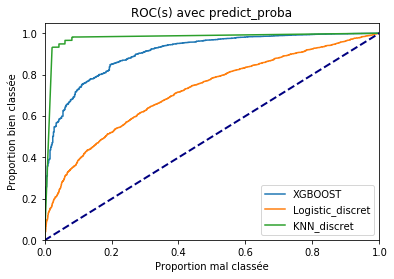

In [163]:
#Courbes ROC des 3 modèles: XGBOOST sur variables normalisées, régression logistique et KNN sur variables discrètes

from sklearn.metrics import roc_curve

fpr_cl = dict()
tpr_cl = dict()


y_pred2=y_pred.astype(int)
y_test2 =y_test.astype(int)

import numpy
prob_pred_XGBOOST = np.array([y_proba[i, 1 if c else 0] for i, c in enumerate(y_pred2)])

fpr_cl["XGBOOST"], tpr_cl["XGBOOST"], _ = roc_curve(
    (y_pred2 == y_test2).ravel(), prob_pred_XGBOOST)

plt.figure()

y_pred_log_discret2 =y_pred_log_discret.astype(int)
y_test_discret2 = y_test_discret.astype(int)


prob_pred_Logistic = np.array([y_proba_log_discret[i, 1 if c else 0] for i, c in enumerate(y_pred_log_discret2)])

fpr_cl["Logistic_discret"], tpr_cl["Logistic_discret"], _ = roc_curve(
    (y_pred_log_discret2 == y_test_discret2).ravel(), prob_pred_Logistic)

plt.figure()

y_pred_KNN_discret2 = y_pred_KNN_discret.astype(int)

prob_pred_KNN = np.array([y_proba_KNN_discret[i, 1 if c else 0] for i, c in enumerate(y_pred_KNN_discret2)])

fpr_cl["KNN_discret"], tpr_cl["KNN_discret"], _ = roc_curve(
    (y_pred_KNN_discret2 == y_test_discret2).ravel(), prob_pred_KNN)

plt.figure()
for key in fpr_cl:
    plt.plot(fpr_cl[key], tpr_cl[key], label=key)

lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Proportion mal classée")
plt.ylabel("Proportion bien classée")
plt.title('ROC(s) avec predict_proba')
plt.legend(loc="lower right")

plt.show()

# Conclusion:
En se considérant comme investisseur ou banquier (accordant des prêts), nous choisirions le modèle des K plus proches voisins, sur variables discrétisées. Un argument de bon sens pour ce modèle est qu'il regroupe naturellement entre elles, les sociétés ayant des caractéristiques financières proches et on peut le supposer des probabilité de défaut équivalentes.
Le fait que le gridsearch (optimisation des paramètres) nous indique avoir choisi commme métrique de poids la distance parait faire totalement sens dans le contexte d'estimation de défaut. En effet, plus des sociétés sont "proches" plus l'on peut supposer qu'elles aient des probabilités de défaut similaire. Ainsi, l'algorithme d'optimisation ayant suggéré d'utiliser les  5 plus proches voisins; si pour une observation, 4 sont très proches et la cinquième plus éloignée, il parait cohérent de pondérer les poids de ses voisins par leurs distances à l'observation.
Les performances de l'algorithme sont intéressantes, avec une probabilité de bonne estimation de plus de 94%, sur les données rééchantillonnées (i.e. autant d'entreprise en faillite qu'en non faillite). L'autre point important, si l'on est investisseur est la matrice de confusion et le faible taux mauvaise classification d'entreprise en faillite. Se tromper sur cette estimation a plus d'impact pour un investisseur.
Ainsi le modèle nous parait exploitable en l'état, comme indiqué au début nous aimerions tester l'appartenance à un secteur, à une industrie, et rajouter une feature representant sa globalisation.

Le modèle peut se dégarder avec le temps si l'on continue à garder tout l'historique. En effet, les conditions macro économiques peuvent changer de façon structurelles et ainsi changer la structure de bilan des entreprise ainsi que leur probabilité de défaut. Nous pouvons à titre d'exemple, illustrer ce point par la baisse structurelle des taux d'intérêt ces 30 dernières années, ayant engendré, toute chose étant égale par ailleurs, de plus grands leviers financiers au sein de entreprises (arrivant à se refinancer à meilleurs conditions). Ainsi une autre piste d'amélioration du modèle sur longue période pourrait être de ne garder que les observations les plus récéntes, et de les comparer à des moyennes historique de longs terme.
Nous pouvons mettre en place un système de détection de dégardation du modèle en comparant les taux de défaut des plus anciennes observations aux plus récentes.

Le modèle peut être passer à l'échelle et être entraîné sur des jeux 10, 100, 1000 fois plus grand, cependant des problèmes de capacité et temps de calcul pourrait intervenir, mais l'algorithme pouvant être parrallélisé, il deviendrait important de de considérer ce développement (GPU ou utilisation de plusieurs machines virtuelles).

Dans un environnent macroéconomique stable, le modèle n'a pas besoin d'être rafraichi de manière fréquente. Cependant le modèle se basant sur des données empiriques fait l'hypothèse de modélisation d'un environnement macroéconomique stable. Ainsi une piste d'amélioration du modèle serait de combiner celui ci avec un modèle macroéconomique global afin d'estimer ces changements.

Le modèle retenu étant simple, ce qui fait la valeur ajoutée de la prédiction est l'accès à cette grande base de données.

